# Diffusion MRI Analysis: Signal Decay and ADC Computation
<b>Ahmed Eldably<b>

This notebook analyzes diffusion MRI datasets using ROI-based signal decay metrics and computes ADC values. The workflow includes:
1. Data preprocessing: Loading DICOM images and extracting ROI metrics.
2. Data analysis: Computing ADC values and analyzing signal decay.
3. Interpretation: Investigating anisotropy and comparing computed ADC maps.


## 1. Introduction

Diffusion-weighted imaging (DWI) is a specialized magnetic resonance imaging (MRI) technique that exploits the diffusion of water molecules to generate contrast and provide insights into tissue microstructure. A key quantitative metric derived from DWI is the apparent diffusion coefficient (ADC), which characterizes the extent and directionality of water diffusion across various tissues and materials. This metric is particularly valuable for understanding biological properties and identifying pathophysiological changes.

In this study, DWI datasets were analyzed for three distinct objects:  
1. **An isotropic phantom**, which serves as a controlled environment to validate the measurement techniques.  
2. **A structured leek phantom**, providing an anisotropic environment to study direction-dependent diffusion.  
3. **A healthy human brain**, illustrating complex diffusion patterns influenced by neural architecture.  

The analysis involves calculating ADC values from signal intensity data acquired at varying \( b \)-values. The primary objectives are to evaluate the isotropy or anisotropy of diffusion, assess the agreement between computed ADC values and theoretical expectations, and investigate how diffusion behavior differs among the three test cases. This report details the methods, results, and interpretations of these analyses, emphasizing their implications for biomedical imaging.


In [4]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pydicom

# Import utility functions
from utils import (
    read_dicom_data_with_directions,
    get_circular_roi,
    compute_adc_values_ranges,
    visualize_image_with_rois,
    visualize_datasets_side_by_side,
    visualize_dataset_with_rois,
    prepare_signal_decay_dataframe,
    plot_signal_decay_per_direction,
    plot_signal_decay_comparison,
    plot_adc_results_rowwise,
    read_adc_maps,
    extract_adc_map_values
)

# Base directories and parameters
base_dir = "data"  # Root directory for datasets
output_dir = "output"  # Directory to save plots and results
b_values = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]


## 2. Data Preprocessing (Section 4.1)

### ROI Definition and Signal Extraction
Regions of interest (ROIs) were defined for each dataset (healthy, isotropic phantom, and leek) to extract signal intensities across all \( b \)-values and directions (`read`, `phase`, `slice`). Circular ROIs were used with predefined centers and radii, ensuring consistent placement across datasets:

- **Healthy Dataset**: Four ROIs were placed in different regions of brain tissue.
- **Isotropic Phantom**: Two ROIs were selected from uniform areas of the phantom.
- **Leek Phantom**: A single ROI was defined in the structured area of the leek.

The ROIs were applied across all images for a given \( b \)-value and direction. Signal intensities within each ROI were extracted using the `get_circular_roi` function and stored in a structured DataFrame and saved as CSV file. This approach allowed systematic analysis of diffusion-weighted signals.

### Dataset Structure
The DICOM datasets were organized by category and direction:
- **Healthy Dataset**: `read`, `phase`, and `slice` directions.
- **Isotropic Phantom**: `read` and `phase` directions.
- **Leek Phantom**: `read`, `phase`, and `slice` directions.

This hierarchical organization ensured clarity in processing and visualization.

In [5]:
# Specify folders containing relevant DICOM data
dataset_folders = {
    "healthy": {
        "read": ["BMT_2_healthy_sub/0003_ep2d_diff_read_subj"],
        "phase": ["BMT_2_healthy_sub/0004_ep2d_diff_phase_subj"],
        "slice": ["BMT_2_healthy_sub/0006_ep2d_diff_slice_subj"]
    },
    "isotropic": {
        "read": ["BMT_P2_1/9001_ep2d_diff_b_variation"],
        "phase": ["BMT_P2_1/10001_ep2d_diff_b_Phase"]
    },
    "leek": {
        "read": ["BMT_P2_1/15001_ep2d_diff_Leek_Ref_Transverse_Read"],
        "phase": ["BMT_P2_1/16001_ep2d_diff_Leek_Ref_Transverse_Phase"],
        "slice": ["BMT_P2_1/17001_ep2d_diff_Leek_Ref_Transverse_Slice"]
    }
}

In [6]:
# Reading and categorizing the data
dicom_data = read_dicom_data_with_directions(base_dir, b_values, dataset_folders)

healthy_data = dicom_data["healthy"]
isotropic_data = dicom_data["isotropic"]
leek_data = dicom_data["leek"]

In [7]:
# Define ROI parameters for Healthy
centers_healthy = [(28, 23), (40, 30), (27, 35), (22, 29)]
radii_healthy = [3, 2, 3, 3]

# Define ROI parameters for Isotropic
centers_isotropic = [(33, 32), (35, 18)]
radii_isotropic= [6, 5]

# Define ROI parameters for Leek
centers_leek = [(32, 34)]
radii_leek= [5]


# Define ROI parameters for all datasets
roi_params = {
    "healthy": {
        "centers": centers_healthy,  # Example for healthy subject
        "radii": radii_healthy
    },
    "isotropic": {
        "centers": centers_isotropic,  # Central regions of isotropic phantom
        "radii": radii_isotropic
    },
    "leek": {
        "centers": centers_leek,
        "radii": radii_leek
    }
}

### Visualization
The datasets were visualized alongside their ROIs to verify accurate placement. The function `visualize_datasets_side_by_side` from the utils file, displayed the ROI locations superimposed on diffusion-weighted images for each \( b \)-value. All the plots can be seen in the output folder.

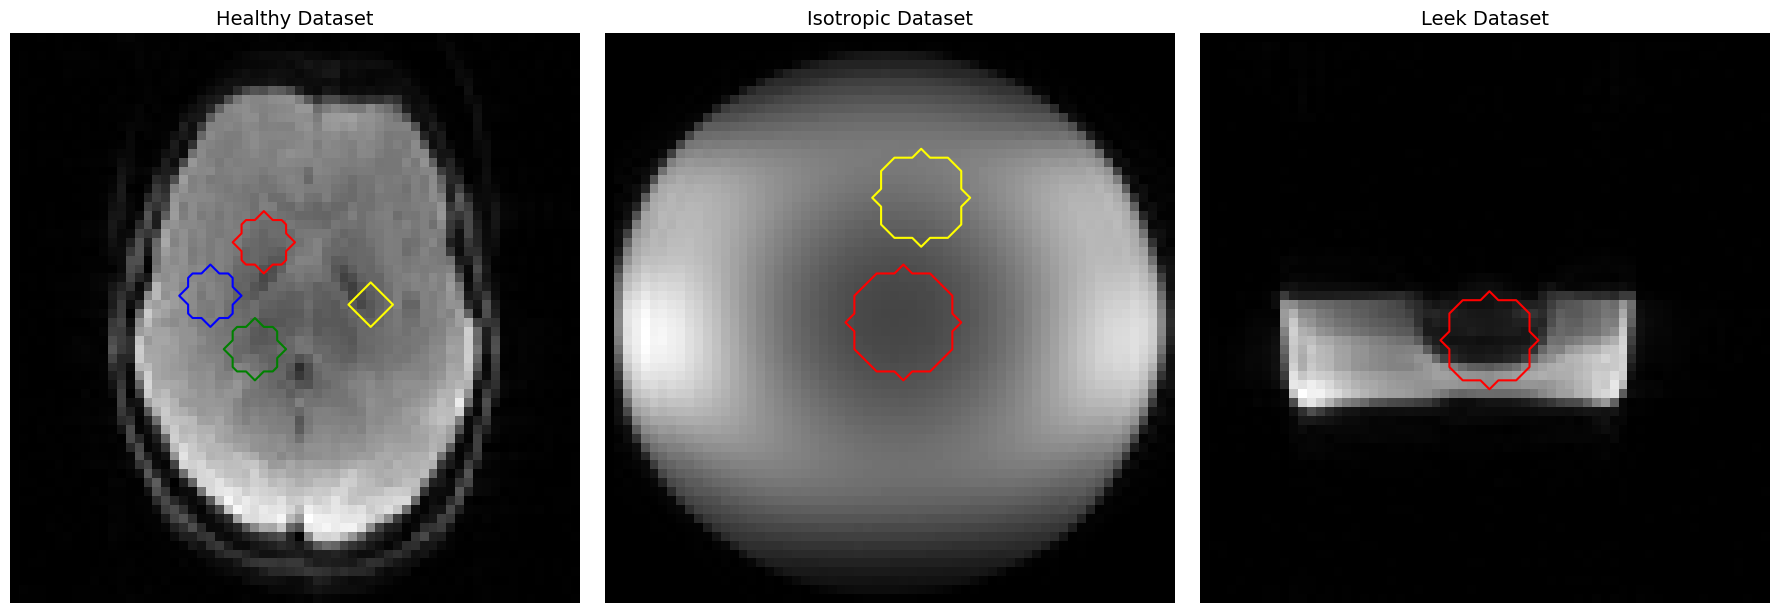

In [8]:
# Prepare dataset dictionary and titles
datasets = {
    "healthy": healthy_data,
    "isotropic": isotropic_data,
    "leek": leek_data
}

titles = ["Healthy Dataset", "Isotropic Dataset", "Leek Dataset"]

# Visualize side by side
visualize_datasets_side_by_side(
    datasets=datasets,
    roi_params=roi_params,
    titles=titles,
    save_path=None, 
    show=True         
)


In [9]:
# Save visualizations for all datasets
output_dirs = {
    "healthy": "output/visualizations/healthy",
    "isotropic": "output/visualizations/isotropic",
    "leek": "output/visualizations/leek"
}

for dataset_name, dataset_data in dicom_data.items():
    print(f"Processing {dataset_name} dataset...")
    
    # Get ROI parameters
    centers = roi_params[dataset_name]["centers"]
    radii = roi_params[dataset_name]["radii"]
    
    # Save path for this dataset
    save_path = output_dirs[dataset_name]
    
    # Save visualizations without showing them
    visualize_dataset_with_rois(
        dataset_data=dataset_data,
        centers=centers,
        radii=radii,
        dataset_name=dataset_name,
        save_path=save_path,
        show=False
    )

Processing healthy dataset...


/Users/ahmedeldably/Downloads/Degrees/MSc/Universität_Tübingen/Modules/Bioimaging_Specialization/Experimental_Radiology/repos/diffusion/utils.py:107: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(mask, colors=[colors[idx % len(colors)]], linewidths=1.5, label=f"ROI {idx + 1}")
/Users/ahmedeldably/Downloads/Degrees/MSc/Universität_Tübingen/Modules/Bioimaging_Specialization/Experimental_Radiology/repos/diffusion/utils.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Plot saved to output/visualizations/healthy/healthy_read_b0.png
Plot saved to output/visualizations/healthy/healthy_read_b100.png
Plot saved to output/visualizations/healthy/healthy_read_b200.png
Plot saved to output/visualizations/healthy/healthy_read_b300.png
Plot saved to output/visualizations/healthy/healthy_read_b400.png
Plot saved to output/visualizations/healthy/healthy_read_b500.png
Plot saved to output/visualizations/healthy/healthy_read_b600.png
Plot saved to output/visualizations/healthy/healthy_read_b700.png
Plot saved to output/visualizations/healthy/healthy_read_b800.png
Plot saved to output/visualizations/healthy/healthy_read_b900.png
Plot saved to output/visualizations/healthy/healthy_read_b1000.png
Plot saved to output/visualizations/healthy/healthy_phase_b0.png
Plot saved to output/visualizations/healthy/healthy_phase_b100.png
Plot saved to output/visualizations/healthy/healthy_phase_b200.png
Plot saved to output/visualizations/healthy/healthy_phase_b300.png
Plot save

In [10]:
# Prepare a combined DataFrame for all datasets
all_data = []

for dataset_name, dataset_data in dicom_data.items():
    # Prepare the DataFrame for the current dataset
    df = prepare_signal_decay_dataframe(
        dataset_data=dataset_data,
        centers=roi_params[dataset_name]["centers"],
        radii=roi_params[dataset_name]["radii"],
        dataset_name=dataset_name
    )
    all_data.append(df)

# Concatenate all dataset DataFrames into one
combined_df = pd.concat(all_data, ignore_index=True)

In [11]:
# 5 Random Samples of the data
combined_df.sample(5)

,File,ROI,Image Number,Mean Intensity,Std Dev,B-Value,Dataset,Direction
116,data/BMT_2_healthy_sub/0006_ep2d_diff_slice_su...,1,30,225.310345,23.528564,700,healthy,slice
17,data/BMT_2_healthy_sub/0003_ep2d_diff_read_sub...,2,5,256.307692,28.044977,400,healthy,read
109,data/BMT_2_healthy_sub/0006_ep2d_diff_slice_su...,2,28,214.923077,28.615385,500,healthy,slice
188,data/BMT_P2_1/16001_ep2d_diff_Leek_Ref_Transve...,1,13,132.543210,109.144716,100,leek,phase
183,data/BMT_P2_1/15001_ep2d_diff_Leek_Ref_Transve...,1,8,43.666667,18.807012,700,leek,read


## 3. Data Analysis

### ADC Calculation
The apparent diffusion coefficient (ADC) was computed using the following equation:

$$
S(b) = S_0 \cdot e^{-b \cdot \text{ADC}}
$$

where:
- $S(b)$: The signal intensity at diffusion weighting $b$,
- $S_0$: The signal intensity when $b = 0$,
- $\text{ADC}$: The apparent diffusion coefficient.

The ADC values were computed for each region of interest (ROI) in the following three ranges of $b$-values:

1. **All $b$-values**: $0$ to $1000 \, \mathrm{s/mm}^2$,
2. **Low $b$-values**: $0$ to $500 \, \mathrm{s/mm}^2$,
3. **High $b$-values**: $600$ to $1000 \, \mathrm{s/mm}^2$.

Curve fitting was applied using the `scipy.optimize.curve_fit` function to extract both $\text{ADC}$ values and $S_0$ for each ROI and measured diffusion direction. The computed results were stored in a DataFrame for subsequent analysis.

### Comparison with Scanner-Derived ADC Maps
The manually computed ADC values were compared with scanner-derived ADC maps for the healthy dataset. This comparison assessed the accuracy of the manual calculations and identified discrepancies between the two methods.


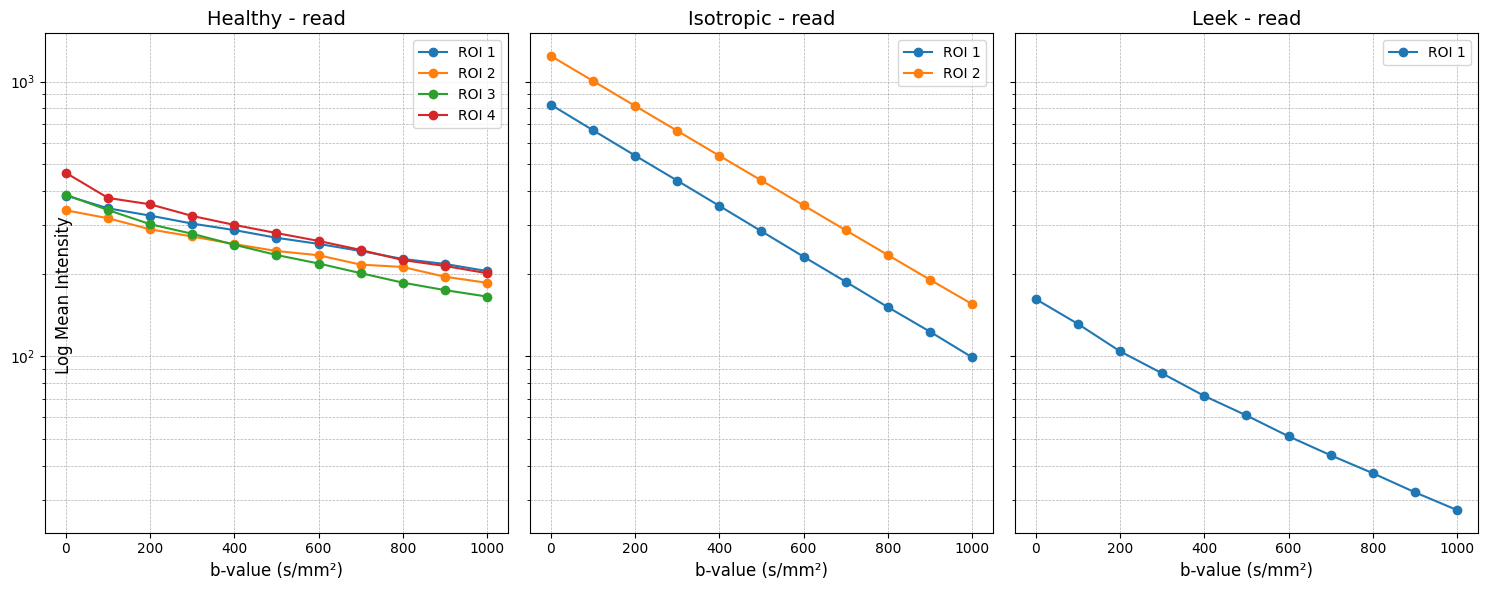

In [12]:
plot_signal_decay_comparison(
    results_df=combined_df,        # DataFrame containing all signal decay metrics
    direction="read",              # Direction to focus on
    log_scale=True,                # Logarithmic Y-axis
    show=True                      # Display the plot
)


In [13]:
# Compute ADC values for all, low, and high b-value ranges
adc_results_ranges = compute_adc_values_ranges(combined_df)

# Display results
adc_results_ranges


,Dataset,ROI,Direction,S0_all,ADC_all,S0_low,ADC_low,S0_high,ADC_high
0,healthy,1,phase,372.072490,0.000909,364.378643,0.000877,339.317953,0.000781
1,healthy,1,read,373.087970,0.000623,367.567728,0.000615,359.599730,0.000567
2,healthy,1,slice,375.160471,0.000691,371.815836,0.000696,334.121934,0.000537
3,healthy,2,phase,333.264251,0.000728,329.337722,0.000728,316.575679,0.000653
4,healthy,2,read,333.560246,0.000606,336.957030,0.000682,325.484404,0.000563
5,healthy,2,slice,332.479285,0.000841,331.516723,0.000880,296.906631,0.000682
6,healthy,3,phase,372.834414,0.000810,366.471854,0.000817,343.851966,0.000689
7,healthy,3,read,372.411458,0.000882,370.589606,0.000936,330.276382,0.000706
8,healthy,3,slice,372.377433,0.000904,373.128680,0.000979,338.286289,0.000758
9,healthy,4,phase,434.382688,0.000920,420.976033,0.000905,380.385617,0.000724


## 4. Results

### 4.1 Isotropic Phantom
- The ADC values across `phase` and `read` directions were consistent, confirming uniform diffusion:
  - ROI 1:  
    $ \text{ADC}_{\text{all}} = 0.002141 \, \mathrm{mm}^2/\mathrm{s} $,  
    $ \text{ADC}_{\text{low}} = 0.002138 \, \mathrm{mm}^2/\mathrm{s} $,  
    $ \text{ADC}_{\text{high}} = 0.002097 \, \mathrm{mm}^2/\mathrm{s} $.
  - ROI 2 showed similar results.
- **Conclusion**: These values validate the ADC computation method for isotropic materials.

### 4.2 Healthy Dataset
- ADC values varied significantly across directions, reflecting anisotropy:
  - ROI 1 (`phase`):  
    $ \text{ADC}_{\text{all}} = 0.000909 \, \mathrm{mm}^2/\mathrm{s} $,  
    $ \text{ADC}_{\text{low}} = 0.000877 \, \mathrm{mm}^2/\mathrm{s} $,  
    $ \text{ADC}_{\text{high}} = 0.000781 \, \mathrm{mm}^2/\mathrm{s} $.
  - ROI 4 (`read`) exhibited higher values, indicating localized tissue variations.
- **Conclusion**: Results highlight the anisotropic nature of brain diffusion.

### 4.3 Leek Phantom
- ADC values showed directional dependence:
  - ROI 1 (`slice`):  
    $ \text{ADC}_{\text{all}} = 0.002025 \, \mathrm{mm}^2/\mathrm{s} $,  
    `phase`: $ \text{ADC}_{\text{all}} = 0.001813 \, \mathrm{mm}^2/\mathrm{s} $.
  - $ \text{ADC}_{\text{low}} > \text{ADC}_{\text{high}} $, reflecting restricted diffusion at higher $ b $-values.
- **Conclusion**: Results confirm anisotropy in the leek's fibrous structure.

### General Trends
- **Isotropic Phantom**: Consistent ADC values validate the method.
- **Healthy and Leek Datasets**: Results emphasize DWI sensitivity to anisotropy and tissue structure.


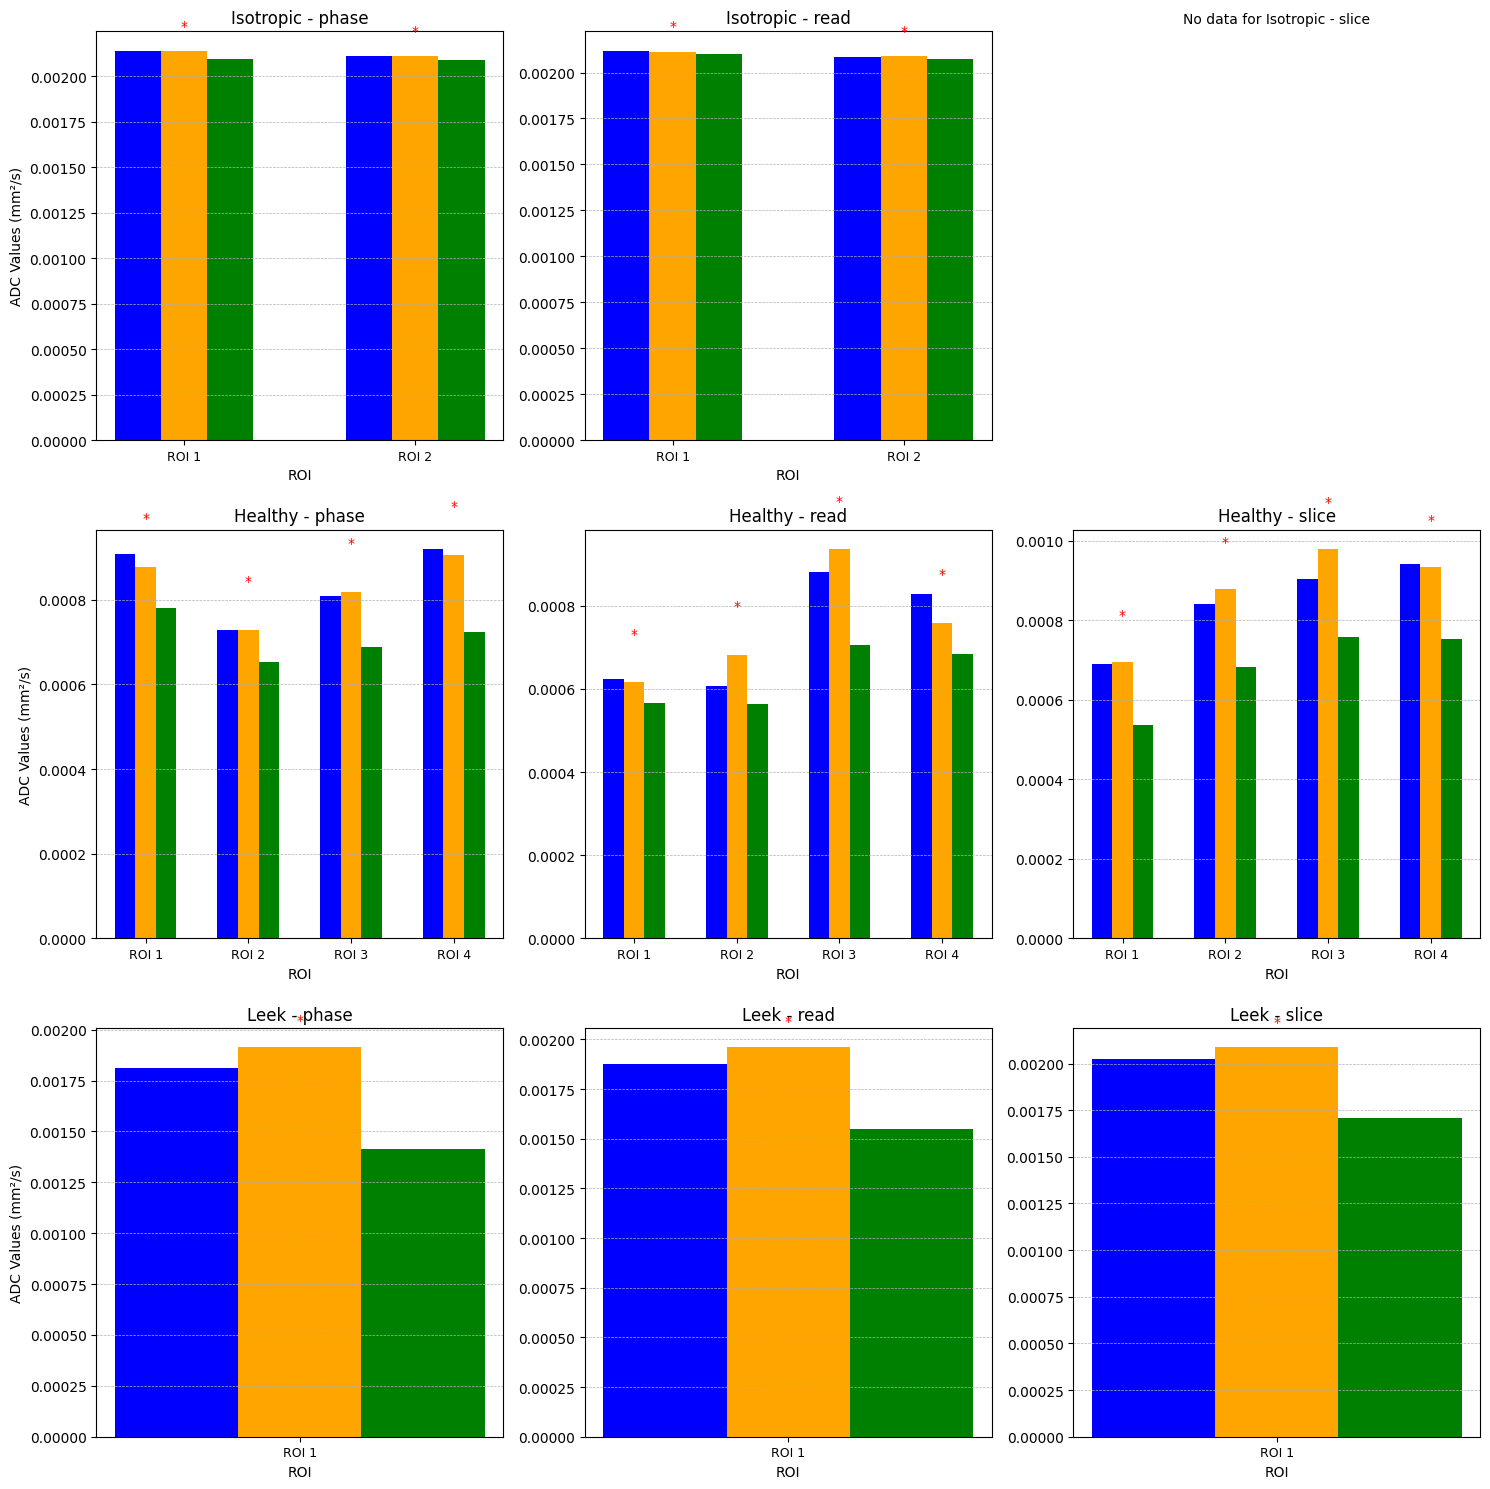

In [14]:
# Plot ADC results in a row-wise layout
plot_adc_results_rowwise(
    adc_df=adc_results_ranges,
    show=True
)


In [15]:
# ADC map folders for Healthy dataset
adc_folders = {
    "healthy": {
        "phase": ["BMT_2_healthy_sub/0005_ep2d_diff_phase_subj_ADC"],
        "slice": ["BMT_2_healthy_sub/0007_ep2d_diff_slice_subj_ADC"]
    }
}

# Load the data
adc_map_data = read_adc_maps(base_dir, adc_folders)

In [16]:
# Extract ADC values from ADC maps for Healthy dataset
adc_map_results = extract_adc_map_values(adc_map_data["healthy"], centers_healthy, radii_healthy)
adc_map_results

,ROI,Direction,Mean ADC,Std Dev ADC
0,1,phase,0.000890,0.000136
1,2,phase,0.000706,0.000107
2,3,phase,0.000779,0.000187
3,4,phase,0.000868,0.000086
4,1,slice,0.000670,0.000163
5,2,slice,0.000814,0.000140
6,3,slice,0.000877,0.000222
7,4,slice,0.000881,0.000077


In [22]:
# Filter manually computed results for healthy dataset
healthy_adc_manual = adc_results_ranges[adc_results_ranges["Dataset"] == "healthy"]

# Merge manual and scanner ADC values
comparison_df = pd.merge(
    healthy_adc_manual.rename(columns={"ADC_all": "Computed ADC"}),  
    adc_map_results.rename(columns={"Mean ADC": "Scanner ADC"}),
    on=["ROI", "Direction"]
)

# Display the merged DataFrame
comparison_df


,Dataset,ROI,Direction,S0_all,Computed ADC,S0_low,ADC_low,S0_high,ADC_high,Scanner ADC,Std Dev ADC
0,healthy,1,phase,372.072490,0.000909,364.378643,0.000877,339.317953,0.000781,0.000890,0.000136
1,healthy,1,slice,375.160471,0.000691,371.815836,0.000696,334.121934,0.000537,0.000670,0.000163
2,healthy,2,phase,333.264251,0.000728,329.337722,0.000728,316.575679,0.000653,0.000706,0.000107
3,healthy,2,slice,332.479285,0.000841,331.516723,0.000880,296.906631,0.000682,0.000814,0.000140
4,healthy,3,phase,372.834414,0.000810,366.471854,0.000817,343.851966,0.000689,0.000779,0.000187
5,healthy,3,slice,372.377433,0.000904,373.128680,0.000979,338.286289,0.000758,0.000877,0.000222
6,healthy,4,phase,434.382688,0.000920,420.976033,0.000905,380.385617,0.000724,0.000868,0.000086
7,healthy,4,slice,433.678118,0.000942,419.033749,0.000934,383.815848,0.000753,0.000881,0.000077


In [24]:
# Calculate absolute and percentage differences
comparison_df["Absolute Difference"] = (
    comparison_df["Computed ADC"] - comparison_df["Scanner ADC"]
).abs()
comparison_df["Percentage Difference (%)"] = (
    comparison_df["Absolute Difference"] / comparison_df["Scanner ADC"]
) * 100

# Display the updated DataFrame
comparison_df

,Dataset,ROI,Direction,S0_all,Computed ADC,S0_low,ADC_low,S0_high,ADC_high,Scanner ADC,Std Dev ADC,Absolute Difference,Percentage Difference (%)
0,healthy,1,phase,372.072490,0.000909,364.378643,0.000877,339.317953,0.000781,0.000890,0.000136,0.000018,2.057097
1,healthy,1,slice,375.160471,0.000691,371.815836,0.000696,334.121934,0.000537,0.000670,0.000163,0.000020,3.048772
2,healthy,2,phase,333.264251,0.000728,329.337722,0.000728,316.575679,0.000653,0.000706,0.000107,0.000023,3.202493
3,healthy,2,slice,332.479285,0.000841,331.516723,0.000880,296.906631,0.000682,0.000814,0.000140,0.000026,3.218392
4,healthy,3,phase,372.834414,0.000810,366.471854,0.000817,343.851966,0.000689,0.000779,0.000187,0.000031,3.919198
5,healthy,3,slice,372.377433,0.000904,373.128680,0.000979,338.286289,0.000758,0.000877,0.000222,0.000027,3.027485
6,healthy,4,phase,434.382688,0.000920,420.976033,0.000905,380.385617,0.000724,0.000868,0.000086,0.000052,5.970652
7,healthy,4,slice,433.678118,0.000942,419.033749,0.000934,383.815848,0.000753,0.000881,0.000077,0.000061,6.932876


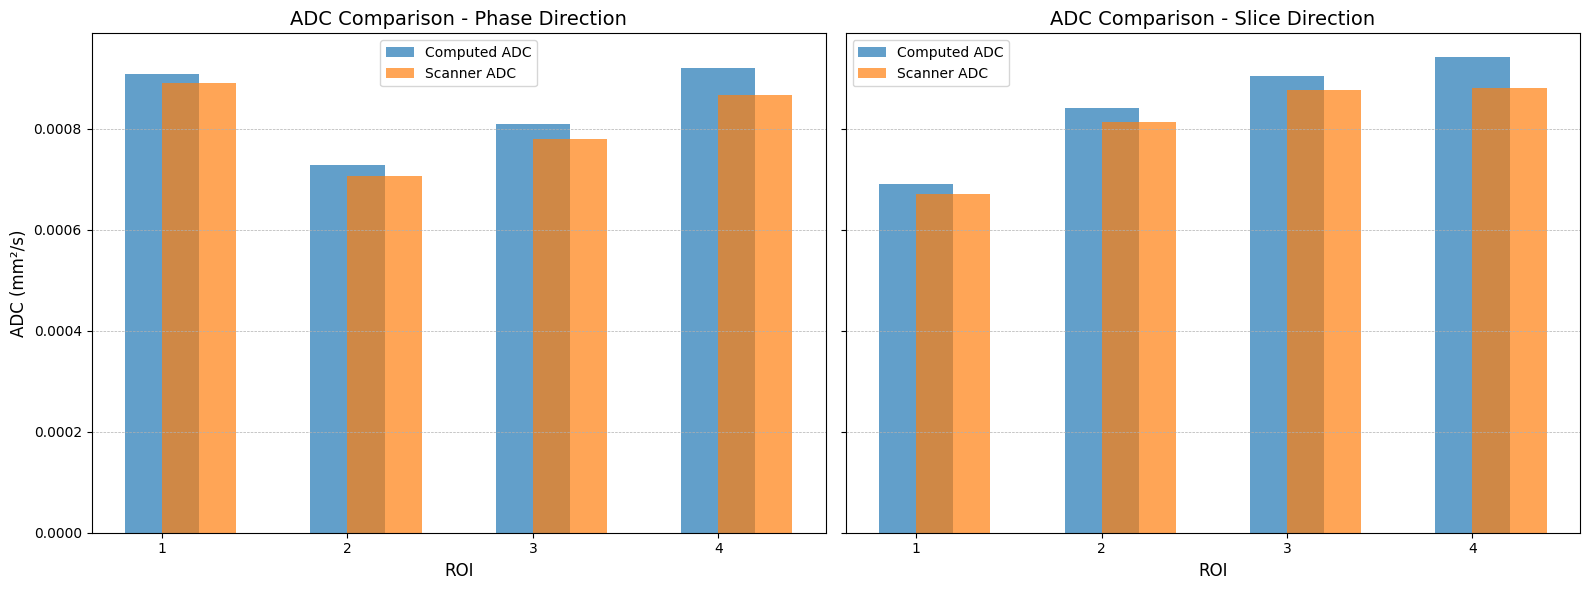

In [27]:
# Create subplots for side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # Two columns for two directions

# Plot for each direction
for idx, direction in enumerate(comparison_df["Direction"].unique()):
    subset = comparison_df[comparison_df["Direction"] == direction]
    ax = axes[idx]

    # Ensure ROIs are treated as categories
    rois = subset["ROI"].astype(str)  # Convert ROI to string for proper labeling

    # Bar plots for Computed ADC and Scanner ADC
    ax.bar(rois, subset["Computed ADC"], width=0.4, label="Computed ADC", alpha=0.7, align="center")
    ax.bar(rois, subset["Scanner ADC"], width=0.4, label="Scanner ADC", alpha=0.7, align="edge")

    # Titles and labels
    ax.set_title(f"ADC Comparison - {direction.capitalize()} Direction", fontsize=14)
    ax.set_xlabel("ROI", fontsize=12)
    if idx == 0:  # Add Y-axis label only on the left plot
        ax.set_ylabel("ADC (mm²/s)", fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(axis="y", linestyle="--", linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.show()


## 5. Discussion

### 5.1 Validation with Isotropic Phantom
- Consistent ADC values confirm the accuracy of the method for isotropic diffusion.
- The absence of `slice` direction data is a minor limitation.

### 5.2 Anisotropy in Healthy Dataset
- Directional variability in ADC values reflects structural anisotropy in brain tissue.
- Manual values closely matched scanner-derived maps, with slight differences attributed to curve-fitting algorithms and ROI placement.

### 5.3 Leek Phantom Findings
- ADC values varied by direction, consistent with the leek's anisotropic structure.
- The difference between $ \text{ADC}_{\text{low}} $ and $ \text{ADC}_{\text{high}} $ highlights restricted diffusion at higher $ b $-values.

### 5.4 Challenges and Limitations
- **ROI Placement**: Variability in placement may influence results.
- **Incomplete Data**: Missing isotropic phantom data in the `slice` direction limited validation.
- **ADC Map Agreement**: Scanner-derived maps aligned well but showed minor discrepancies.

### Key Takeaways
- The study confirmed the reliability of ADC calculations for isotropic and anisotropic diffusion.
- Improvements in data collection and ROI placement could enhance analysis robustness.


## 6. Conclusion

This study analyzed diffusion-weighted MRI data for isotropic and anisotropic objects and a human brain, successfully computing ADC values across \( b \)-values and directions. The results demonstrated:
- Uniform diffusion in isotropic phantoms,
- Direction-dependent diffusion in anisotropic objects and brain tissue,
- Differences in ADC values based on \( b \)-value ranges, reflecting varying diffusion sensitivities.

This analysis emphasizes the utility of DWI and ADC metrics for characterizing diffusion properties in biomedical imaging.

## References

1. Bammer, R. (2003). Basic principles of diffusion-weighted imaging. European journal of radiology, 45(3), 169-184.
2. Baliyan, V., Das, C. J., Sharma, R., & Gupta, A. K. (2016). Diffusion weighted imaging: technique and applications. World journal of radiology, 8(9), 785.
3. Le Bihan, D. (2013). Apparent diffusion coefficient and beyond: what diffusion MR imaging can tell us about tissue structure. Radiology, 268(2), 318-322.
4. Yamasaki, F., Kurisu, K., Satoh, K., Arita, K., Sugiyama, K., Ohtaki, M., ... & Thohar, M. A. (2005). Apparent diffusion coefficient of human brain tumors at MR imaging. Radiology, 235(3), 985-991.